In [2]:
import ezkl
import torch
from torch import nn
import json
import os
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math

In [3]:
%run -i ../../bench.py

In [4]:
data_sm_50_path = os.path.join('data_sm_50.json')
data_sm_100_path = os.path.join('data_sm_100.json')
data_sm_300_path = os.path.join('data_sm_300.json')
data_sm_600_path = os.path.join('data_sm_600.json')
data_sm_1000_path = os.path.join('data_sm_1000.json')
data_med_50_path = os.path.join('data_med_50.json')
data_med_100_path = os.path.join('data_med_100.json')
data_med_300_path = os.path.join('data_med_300.json')
data_med_600_path = os.path.join('data_med_600.json')
data_med_1000_path = os.path.join('data_med_1000.json')
data_lar_50_path = os.path.join('data_lar_50.json')
data_lar_100_path = os.path.join('data_lar_100.json')
data_lar_300_path = os.path.join('data_lar_300.json')
data_lar_600_path = os.path.join('data_lar_600.json')
data_lar_1000_path = os.path.join('data_lar_1000.json')

In [5]:
def gen_param_func(data_tensor_array):
    # for 1 column, just have 1 element in tensor array
    data = data_tensor_array[0].reshape(-1).numpy()
    return [torch.tensor(np.median(data)),torch.tensor(np.sort(data)[int(len(data)/2)-1]), torch.tensor(np.sort(data)[int(len(data)/2)]) ]
    return [torch.tensor(np.median(data)),torch.tensor(np.sort(data, axis = 1)[0][int(len(data[0])/2)-1][0]), torch.tensor(np.sort(data, axis = 1)[0][int(len(data[0])/2)][0]) ]

def model_func(param):
    # print("median: ", param[0])
    # print("lower: ", param[1])
    # print("upper: ", param[2])
    class verifier_model(nn.Module):
        def __init__(self):
            super(verifier_model, self).__init__()
            self.w = nn.Parameter(data = param[0], requires_grad = False)
            self.lower = nn.Parameter(data = param[1], requires_grad = False)
            self.upper = nn.Parameter(data = param[2], requires_grad = False)

        def forward(self,X):
            # since within 1%, we regard as same value
            count_less = torch.sum((X < 0.99*self.w).double())
            count_equal = torch.sum((torch.abs(X-self.w)<=torch.abs(0.01*self.w)).double())
            len = X.size()[1]
            half_len = torch.floor(torch.div(len, 2))
        
            # not support modulo yet
            less_cons = count_less<half_len+2*(len/2 - torch.floor(len/2))
            more_cons = count_less+count_equal>half_len

            # For count_equal == 0
            lower_exist = torch.sum((torch.abs(X-self.lower)<=torch.abs(0.01*self.lower)).double())>0
            lower_cons = torch.sum((X>1.01*self.lower).double())==half_len
            upper_exist = torch.sum((torch.abs(X-self.upper)<=torch.abs(0.01*self.upper)).double())>0
            upper_cons = torch.sum((X<0.99*self.upper).double())==half_len
            bound = count_less==half_len
            # 0.02 since 2*0.01
            bound_avg = (torch.abs(self.lower+self.upper-2*self.w)<=torch.abs(0.02*self.w))

            median_in_cons = torch.logical_and(less_cons, more_cons)
            median_out_cons = torch.logical_and(torch.logical_and(bound, bound_avg), torch.logical_and(torch.logical_and(lower_cons, upper_cons), torch.logical_and(lower_exist, upper_exist)))
        
            return(torch.where(count_equal==0, median_out_cons, median_in_cons), self.w)

    return verifier_model

Summary of Proving Time (1% accuracy)

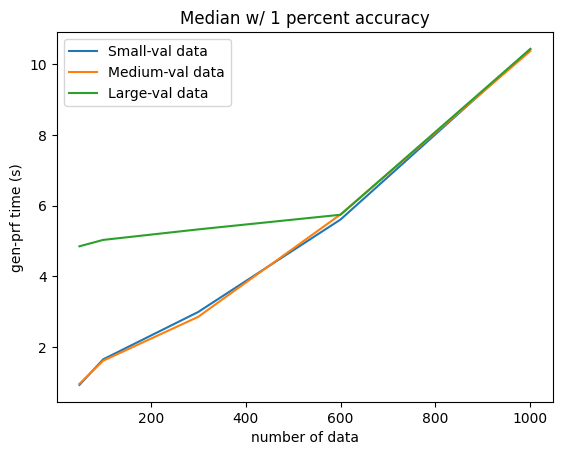

In [28]:
# Hence calibrate scale accordingly to compres the circuit size as long as the answer still within 1 percent
import matplotlib.pyplot as plt
data_number = [50, 100, 300, 600, 1000]
sm_time = [0.9221072196960449, 1.6463661193847656, 2.9852941036224365, 5.603499889373779, 10.428229093551636]
plt.title("Median w/ 1 percent accuracy")
plt.xlabel("number of data")
plt.ylabel("gen-prf time (s)")
plt.plot(data_number, sm_time, label = 'Small-val data')

med_time = [0.95278000831604, 1.6076688766479492, 2.848428726196289, 5.747658014297485, 10.373636245727539]
plt.plot(data_number, med_time, label = 'Medium-val data')

lar_time = [4.8463828563690186, 5.027441024780273, 5.324703931808472, 5.739445924758911, 10.433889865875244]
plt.plot(data_number, lar_time, label = 'Large-val data')


plt.legend()


=============================================================================================================

Small-Valued Data: value 0-1, 3 decimals on 50, 100, 300, 600, 1000 data

In [5]:
bench_one([data_sm_50_path], model_func,gen_param_func, "50 small values","default", "resources")

=====================================  50 small values  =====================================


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:2174: FutureWarning: 'torch.onnx.symbolic_opset9._cast_Bool' is deprecated in version 2.0 and will be removed in the future. Please Avoid using this function and create a Cast node instead.
  return fn(g, to_cast_func(g, input, False), to_cast_func(g, other, False))
spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":9,"param_scale":9,"scale_rebase_multiplier":10,"lookup_range":[-516,1024],"logrows":12,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":3936,"total_assignments":2046,"total_const_size":316,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,9],"model_input_scales":[9],"module_sizes":{"kzg":[],"poseidon":[3936,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  0.9221072196960449
Theory result:  tensor(0.5160, dtype=torch.float64)
Our result:  [0.515625]


In [11]:
bench_one([data_sm_100_path], model_func,gen_param_func, "100 small values","default", "resources")

=====================================  100 small values  =====================================


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:2174: FutureWarning: 'torch.onnx.symbolic_opset9._cast_Bool' is deprecated in version 2.0 and will be removed in the future. Please Avoid using this function and create a Cast node instead.
  return fn(g, to_cast_func(g, input, False), to_cast_func(g, other, False))
spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":9,"param_scale":9,"scale_rebase_multiplier":10,"lookup_range":[-1024,2048],"logrows":13,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":6560,"total_assignments":4046,"total_const_size":616,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,9],"model_input_scales":[9],"module_sizes":{"kzg":[],"poseidon":[6560,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  1.6463661193847656
Theory result:  tensor(0.4975, dtype=torch.float64)
Our result:  [0.498046875]


In [7]:
bench_one([data_sm_300_path], model_func,gen_param_func, "300 small values","default", "resources")

=====================================  300 small values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":9,"param_scale":9,"scale_rebase_multiplier":10,"lookup_range":[-6144,7168],"logrows":14,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":14432,"total_assignments":12046,"total_const_size":1816,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,9],"model_input_scales":[9],"module_sizes":{"kzg":[],"poseidon":[14432,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  2.9852941036224365
Theory result:  tensor(0.4890, dtype=torch.float64)
Our result:  [0.48828125]


In [12]:
bench_one([data_sm_600_path], model_func,gen_param_func, "600 small values","default", "resources")

=====================================  600 small values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":9,"param_scale":9,"scale_rebase_multiplier":10,"lookup_range":[-4096,5120],"logrows":15,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":26240,"total_assignments":24046,"total_const_size":3616,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,9],"model_input_scales":[9],"module_sizes":{"kzg":[],"poseidon":[26240,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.603499889373779
Theory result:  tensor(0.4780, dtype=torch.float64)
Our result:  [0.478515625]


In [15]:
bench_one([data_sm_1000_path], model_func,gen_param_func, "1000 small values","default", "resources")

=====================================  1000 small values  =====================================


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:2174: FutureWarning: 'torch.onnx.symbolic_opset9._cast_Bool' is deprecated in version 2.0 and will be removed in the future. Please Avoid using this function and create a Cast node instead.
  return fn(g, to_cast_func(g, input, False), to_cast_func(g, other, False))
spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":9,"param_scale":9,"scale_rebase_multiplier":10,"lookup_range":[-8192,19456],"logrows":16,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":45920,"total_assignments":40046,"total_const_size":6016,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,9],"model_input_scales":[9],"module_sizes":{"kzg":[],"poseidon":[45920,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  10.428229093551636
Theory result:  tensor(0.5005, dtype=torch.float64)
Our result:  [0.5]


=============================================================================================================

Medium data: value 1-100, 1 decimal on 50, 100, 300, 600, 1000 data

In [19]:
# can use "default" which will set to scale 8, but overkill, we just want 1% accuracy
bench_one([data_med_50_path], model_func,gen_param_func, "50 medium values",[3], "resources")

spawning module 0
spawning module 2


=====================================  50 medium values  =====================================
setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":3,"param_scale":3,"scale_rebase_multiplier":10,"lookup_range":[-976,986],"logrows":12,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":3936,"total_assignments":2046,"total_const_size":316,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,3],"model_input_scales":[3],"module_sizes":{"kzg":[],"poseidon":[3936,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  0.95278000831604
Theory result:  tensor(39.3000, dtype=torch.float64)
Our result:  [39.25]


In [18]:
bench_one([data_med_100_path], model_func,gen_param_func, "100 medium values",[3], "resources")

spawning module 0
spawning module 2


=====================================  100 medium values  =====================================
setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":3,"param_scale":3,"scale_rebase_multiplier":10,"lookup_range":[-798,804],"logrows":13,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":6560,"total_assignments":4046,"total_const_size":616,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,3],"model_input_scales":[3],"module_sizes":{"kzg":[],"poseidon":[6560,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  1.6076688766479492
Theory result:  tensor(49.1500, dtype=torch.float64)
Our result:  [49.125]


In [20]:
bench_one([data_med_300_path], model_func,gen_param_func, "300 medium values",[3], "resources")

=====================================  300 medium values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":3,"param_scale":3,"scale_rebase_multiplier":10,"lookup_range":[-786,782],"logrows":14,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":14432,"total_assignments":12046,"total_const_size":1816,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,3],"model_input_scales":[3],"module_sizes":{"kzg":[],"poseidon":[14432,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  2.848428726196289
Theory result:  tensor(49.5500, dtype=torch.float64)
Our result:  [49.5]


In [21]:
bench_one([data_med_600_path], model_func,gen_param_func, "600 medium values",[3], "resources")

=====================================  600 medium values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":3,"param_scale":3,"scale_rebase_multiplier":10,"lookup_range":[-820,812],"logrows":15,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":26240,"total_assignments":24046,"total_const_size":3616,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,3],"model_input_scales":[3],"module_sizes":{"kzg":[],"poseidon":[26240,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.747658014297485
Theory result:  tensor(49.2000, dtype=torch.float64)
Our result:  [49.25]


In [22]:
bench_one([data_med_1000_path], model_func,gen_param_func, "1000 medium values",[3], "resources")

=====================================  1000 medium values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":3,"param_scale":3,"scale_rebase_multiplier":10,"lookup_range":[-822,808],"logrows":16,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":45920,"total_assignments":40046,"total_const_size":6016,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,3],"model_input_scales":[3],"module_sizes":{"kzg":[],"poseidon":[45920,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  10.373636245727539
Theory result:  tensor(52.0500, dtype=torch.float64)
Our result:  [52.0]


=============================================================================================================

Large-valued data: value 100-10000, 0 decimal on 50, 100, 300, 600, 1000 data

In [23]:
bench_one([data_lar_50_path], model_func,gen_param_func, "50 large values",[0], "resources")

spawning module 0
spawning module 2


=====================================  50 large values  =====================================
setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":0,"param_scale":0,"scale_rebase_multiplier":10,"lookup_range":[-9448,9438],"logrows":15,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":3936,"total_assignments":2037,"total_const_size":308,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,0],"model_input_scales":[0],"module_sizes":{"kzg":[],"poseidon":[3936,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  4.8463828563690186
Theory result:  tensor(5344.5000, dtype=torch.float64)
Our result:  [5345.0]


In [24]:
bench_one([data_lar_100_path], model_func,gen_param_func, "100 large values",[0], "resources")

=====================================  100 large values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":0,"param_scale":0,"scale_rebase_multiplier":10,"lookup_range":[-11174,11124],"logrows":15,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":6560,"total_assignments":4037,"total_const_size":608,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,0],"model_input_scales":[0],"module_sizes":{"kzg":[],"poseidon":[6560,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.027441024780273
Theory result:  tensor(4394., dtype=torch.float64)
Our result:  [4394.0]


In [25]:
bench_one([data_lar_300_path], model_func,gen_param_func, "300 large values",[0], "resources")

=====================================  300 large values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":0,"param_scale":0,"scale_rebase_multiplier":10,"lookup_range":[-9948,9886],"logrows":15,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":14432,"total_assignments":12037,"total_const_size":1808,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,0],"model_input_scales":[0],"module_sizes":{"kzg":[],"poseidon":[14432,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.324703931808472
Theory result:  tensor(5062.5000, dtype=torch.float64)
Our result:  [5063.0]


In [26]:
bench_one([data_lar_600_path], model_func,gen_param_func, "600 large values",[0], "resources")

=====================================  600 large values  =====================================


spawning module 0
spawning module 2


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":0,"param_scale":0,"scale_rebase_multiplier":10,"lookup_range":[-10552,10464],"logrows":15,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":26240,"total_assignments":24037,"total_const_size":3608,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,0],"model_input_scales":[0],"module_sizes":{"kzg":[],"poseidon":[26240,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.739445924758911
Theory result:  tensor(4764.5000, dtype=torch.float64)
Our result:  [4765.0]


In [27]:
bench_one([data_lar_1000_path], model_func,gen_param_func, "1000 large values",[0], "resources")

=====================================  1000 large values  =====================================


spawning module 0
spawning module 2
spawning module 0


setting:  {"run_args":{"tolerance":{"val":0.0,"scale":1.0},"input_scale":0,"param_scale":0,"scale_rebase_multiplier":10,"lookup_range":[-10088,9998],"logrows":16,"num_inner_cols":2,"variables":[["batch_size",1]],"input_visibility":{"Hashed":{"hash_is_public":true,"outlets":[]}},"output_visibility":"Public","param_visibility":"Private"},"num_rows":45920,"total_assignments":40037,"total_const_size":6008,"model_instance_shapes":[[1],[1]],"model_output_scales":[0,0],"model_input_scales":[0],"module_sizes":{"kzg":[],"poseidon":[45920,[1]],"elgamal":[0,[0]]},"required_lookups":["Abs",{"GreaterThan":{"a":0.0}},"KroneckerDelta"],"check_mode":"UNSAFE","version":"7.0.0","num_blinding_factors":null}


spawning module 2
spawning module 0
spawning module 2


gen prf time:  10.433889865875244
Theory result:  tensor(4998.5000, dtype=torch.float64)
Our result:  [4999.0]
